In [31]:
# Imports

import importlib
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats, fft
import scipy.signal as signal
import statsmodels.api as sm
import seaborn as sns
import math
import numpy as np
import matplotlib as mpl
import os
from matplotlib.ticker import FormatStrFormatter
# from pyts.decomposition import SingularSpectrumAnalys is
import nktools as nk
import nkplot as nkp
import inspect
import re
from dotmap import DotMap
from scipy.optimize import curve_fit


importlib.reload(nk)
importlib.reload(nkp)

#plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'

# some info for charting
# Some universal graphic constants
std_mult = 3
neg_std_mult = 3
cm = 1/2.54


# rando tools
def find_slope(df, endtime, start_time=0, intercept=False):
    # we assume df has its index as the time and then a number of columns, one per replicate

    pdf = df.loc[start_time:endtime]
    # print(pdf)

    x = np.array([])
    y = np.array([])
    for col in pdf.columns:
        x = np.append(x, pdf.index.array)
        y = np.append(y, pdf[col])

    p = np.polyfit(x, y,  1)

    if intercept:
        return p
    else:
        return p[0]


def xy(df):
    x = []
    y = []
    for col in df.columns:
        x = np.append(x, df.index.array)
        y = np.append(y, df[col])

    return x, y


# Fig A and B: Pure Kinetic Comparison

In [32]:
f2_path = '../../data/raw_data/02062023_tamravsBHQ1_FULLPLATE_newconcentrationsDYE.csv'

bhq_well_dict = {
    'neg': {'H2', 'H3', 'H4', 'H5', 'H6'},  # negtive
    'low': {'G2', 'G3', 'G4', 'G5', 'G6'},  # '2pM HPV16 Target DNA'
    'med': {'F2', 'F3', 'F4', 'F5', 'F6'},  # '20pM HPV16 Target DNA'
    'high': {'E2', 'E3', 'E4', 'E5', 'E6'},  # '200pM HPV16 Target DNA'
}

TAMRA_well_dict = {
    'neg': {'D2', 'D3', 'D4', 'D5', 'D6'},  # negtive
    'low': {'C2', 'C3', 'C4', 'C5', 'C6'},  # '2pM HPV16 Target DNA'
    'med': {'B2', 'B3', 'B4', 'B5', 'B6'},  # '20pM HPV16 Target DNA'
    'high': {'A2', 'A3', 'A4', 'A5', 'A6'},  # '200pM HPV16 Target DNA'
}

bhq_dict = nk.read_and_process_quotient_data(f2_path, bhq_well_dict)
TAMRA_dict = nk.read_and_process_quotient_data(f2_path, TAMRA_well_dict)

bhq_FAM_neg = bhq_dict['neg_FAM_data']
bhq_FAM_low = bhq_dict['low_FAM_data']
bhq_FAM_med = bhq_dict['med_FAM_data']
bhq_FAM_high = bhq_dict['high_FAM_data']

TAMRA_FAM_neg = TAMRA_dict['neg_FAM_data']
TAMRA_FAM_low = TAMRA_dict['low_FAM_data']
TAMRA_FAM_med = TAMRA_dict['med_FAM_data']
TAMRA_FAM_high = TAMRA_dict['high_FAM_data']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


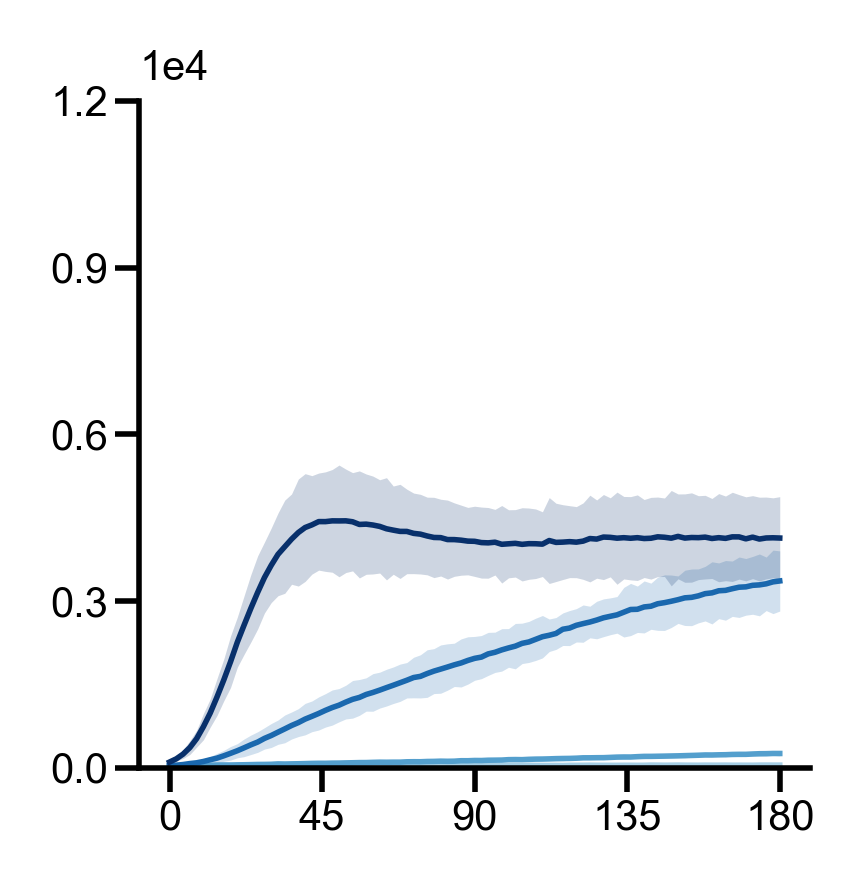

In [33]:
# BHQ

x_bhq = nk.tc(bhq_FAM_neg.index)
lns_bhq = [[x_bhq, bhq_FAM_neg.mean(axis=1)], [x_bhq, bhq_FAM_low.mean(axis=1)], [x_bhq, bhq_FAM_med.mean(axis=1)],
           [x_bhq, bhq_FAM_high.mean(axis=1)]]
errs_bhq = [bhq_FAM_neg.std(axis=1), bhq_FAM_low.std(axis=1),
            bhq_FAM_med.std(axis=1), bhq_FAM_high.std(axis=1)]
labels_bhq = ['Neg', '2pM', '20pM', '200pM']
axis_names_bhq = ['Time (min)', 'FAM Fluorescence']

bhq_axp = nkp.AxisPackage(lns_bhq, labels_bhq, errs_bhq, axis_names_bhq)

axis_packages = [[bhq_axp]]
fig, ax = nkp.general_lineplot_errorfill(
    axis_packages, stdmult=std_mult, neg_std_mult=neg_std_mult, publish_ready=True, figsize=(4.4*cm, 4.4*cm), dpi=500)

a = ax[0][0]
a.set_ylim([0, 12000])
a.set_yticks([0, 3000, 6000, 9000, 12000])
a.set_xticks([0, 45, 90, 135, 180])
a.tick_params(axis='both', which='major', pad=1)

plt.savefig('./charts/2A_BHQ_Kinetic_Reads.png', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2A_BHQ_Kinetic_Reads.svg', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2A_BHQ_Kinetic_Reads.eps', dpi=2000, bbox_inches='tight')


(-16.504852263471207, 11484.755572950366)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


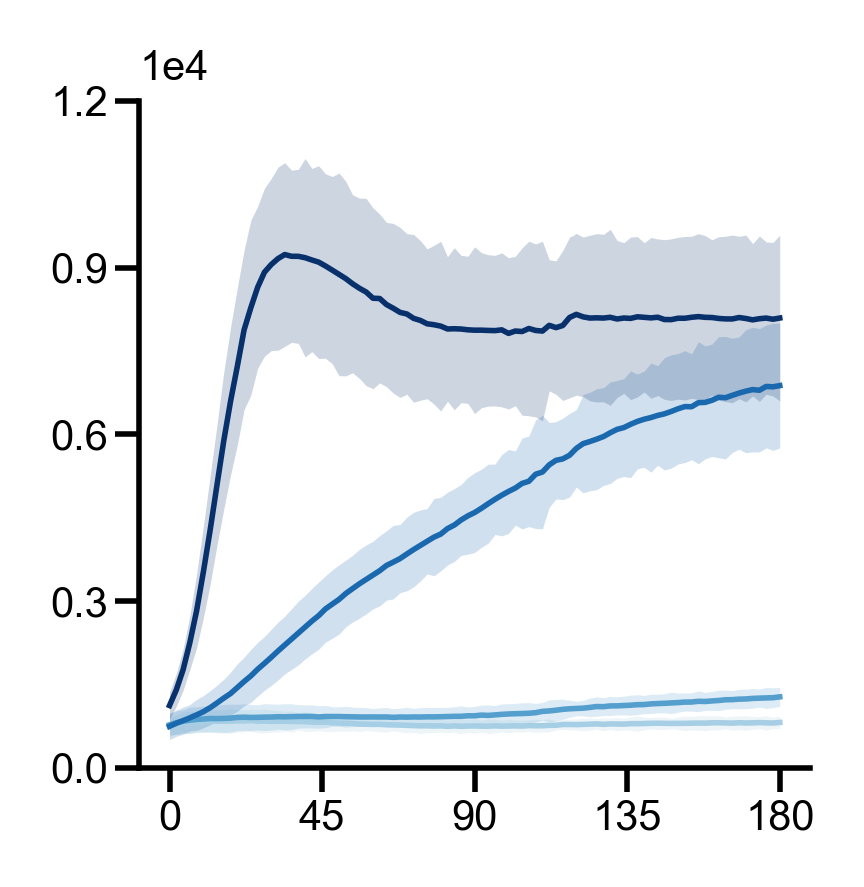

In [34]:
# TAMRA

x_TAMRA = nk.tc(TAMRA_FAM_neg.index)
lns_TAMRA = [[x_TAMRA, TAMRA_FAM_neg.mean(axis=1)], [x_TAMRA, TAMRA_FAM_low.mean(axis=1)], [x_TAMRA, TAMRA_FAM_med.mean(axis=1)],
             [x_TAMRA, TAMRA_FAM_high.mean(axis=1)]]
errs_TAMRA = [TAMRA_FAM_neg.std(axis=1), TAMRA_FAM_low.std(axis=1),
              TAMRA_FAM_med.std(axis=1), TAMRA_FAM_high.std(axis=1)]
labels_TAMRA = ['Neg', '2pM', '20pM', '200pM']
axis_names_TAMRA = ['Time (s)', 'FAM Fluorescence']

tamra_axp = nkp.AxisPackage(lns_TAMRA, labels_TAMRA,
                            errs_TAMRA, axis_names_TAMRA)


axis_packages = [[tamra_axp]]
fig, ax = nkp.general_lineplot_errorfill(
    axis_packages, stdmult=std_mult, neg_std_mult=neg_std_mult, publish_ready=True, figsize=(4.4*cm, 4.4*cm), dpi=500)

print(ax[0][0].get_ylim())

a = ax[0][0]
a.set_ylim([0, 12000])
a.set_yticks([0, 3000, 6000, 9000, 12000])
a.set_xticks([0, 45, 90, 135, 180])
a.tick_params(axis='both', which='major', pad=1)

plt.savefig('./charts/2B_TAMRA_Kinetic_Reads.png',
            dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2B_TAMRA_Kinetic_Reads.svg',
            dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2B_TAMRA_Kinetic_Reads.eps',
            dpi=2000, bbox_inches='tight')


#  BHQ Kinetics

In [35]:
# Read in Data

wells = {
    'bhq_0nm': ['H16', 'H17', 'H18'],
    'bhq_1nm': ['G16', 'G17', 'G18'],
    'bhq_10nm': ['F16', 'F17', 'F18'],
    'bhq_100nm': ['E16', 'E17', 'E18'],
    'bhq_200nm': ['D16', 'D17', 'D18'],
    'bhq_500nm': ['C16', 'C17', 'C18'],
    'bhq_1000nm': ['B16', 'B17', 'B18'],
    'bhq_2000nm': ['A16', 'A17', 'A18'],
    'tamra_0nm': ['H13', 'H14', 'H15'],
    'tamra_1nm': ['G13', 'G14', 'G15'],
    'tamra_10nm': ['F13', 'F14', 'F15'],
    'tamra_100nm': ['E13', 'E14', 'E15'],
    'tamra_200nm': ['D13', 'D14', 'D15'],
    'tamra_500nm': ['C13', 'C14', 'C15'],
    'tamra_1000nm': ['B13', 'B14', 'B15'],
    'tamra_2000nm': ['A13', 'A14', 'A15']
}

filename = '../../data/raw_data/11082023_kineticstudy.csv'
all_data = nk.read_and_process_general_conc_quotient_data(
    filename, wells, fam_range=(62, 119), tamra_range=(123, 180))

# set teh data up
raw_data = DotMap({
    'bhq_0nm': all_data.bhq_0nm.fam,
    'bhq_1nm': all_data.bhq_1nm.fam,
    'bhq_10nm': all_data.bhq_10nm.fam,
    'bhq_100nm': all_data.bhq_100nm.fam,
    'bhq_200nm': all_data.bhq_200nm.fam,
    'bhq_500nm': all_data.bhq_500nm.fam,
    'bhq_1000nm': all_data.bhq_1000nm.fam,
    'bhq_2000nm': all_data.bhq_2000nm.fam,
    'tamra_0nm': all_data.tamra_0nm.fam,
    'tamra_1nm': all_data.tamra_1nm.fam,
    'tamra_10nm': all_data.tamra_10nm.fam,
    'tamra_100nm': all_data.tamra_100nm.fam,
    'tamra_200nm': all_data.tamra_200nm.fam,
    'tamra_500nm': all_data.tamra_500nm.fam,
    'tamra_1000nm': all_data.tamra_1000nm.fam,
    'tamra_2000nm': all_data.tamra_2000nm.fam
})


/Users/nathankosla/code_and_projects/FRET_Reporter/code/final_charts/nktools.py:80: RuntimeWarning: invalid value encountered in scalar divide
  t1 = (stdevs1[k] / means1[k])**2
/Users/nathankosla/code_and_projects/FRET_Reporter/code/final_charts/nktools.py:82: RuntimeWarning: invalid value encountered in scalar divide
  t3 = -2 * cov / (means1[k] * means2[k])
/Users/nathankosla/code_and_projects/FRET_Reporter/code/final_charts/nktools.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  f = means1[k] / means2[k]
/Users/nathankosla/code_and_projects/FRET_Reporter/code/final_charts/nktools.py:81: RuntimeWarning: invalid value encountered in scalar divide
  t2 = (stdevs2[k] / means2[k])**2
/Users/nathankosla/code_and_projects/FRET_Reporter/code/final_charts/nktools.py:82: RuntimeWarning: invalid value encountered in scalar divide
  t3 = -2 * cov / (means1[k] * means2[k])
/Users/nathankosla/code_and_projects/FRET_Reporter/code/final_charts/nktools.py:79: RuntimeWarning: di

In [36]:
# Make an RFU to nM conversion for the bhq data
def linear(x, m, b): return m*x + b


cal_conc = [0, 10, 100, 200, 500]

cal_rfubhq = [raw_data.bhq_0nm.tail(3).mean(axis=1).mean(axis=0),
              raw_data.bhq_10nm.tail(3).mean(axis=1).mean(axis=0),
              raw_data.bhq_100nm.tail(3).mean(axis=1).mean(axis=0),
              raw_data.bhq_200nm.tail(3).mean(axis=1).mean(axis=0),
              raw_data.bhq_500nm.tail(3).mean(axis=1).mean(axis=0)]


popt_bhq, pcov_bhq = curve_fit(linear, cal_conc, cal_rfubhq)


def rfu_to_nm_bhq(rfu): return (rfu - popt_bhq[1]) / popt_bhq[0]


print(popt_bhq)
print('BHQ: rfu = {} * nM + {}'.format(popt_bhq[0], popt_bhq[1]))

# Make an RFU to nM conversion for the tamra data

cal_rfu_tamra = [raw_data.tamra_0nm.tail(3).mean(axis=1).mean(axis=0),
                 raw_data.tamra_10nm.tail(3).mean(axis=1).mean(axis=0),
                 raw_data.tamra_100nm.tail(3).mean(axis=1).mean(axis=0),
                 raw_data.tamra_200nm.tail(3).mean(axis=1).mean(axis=0),
                 raw_data.tamra_500nm.tail(3).mean(axis=1).mean(axis=0)]

cal_rfubhq = cal_rfubhq[0:4]
cal_rfu_tamra = cal_rfu_tamra[0:4]
cal_conc = cal_conc[0:4]

popt_tamra, pcov_tamra = curve_fit(linear, cal_conc, cal_rfu_tamra)


def rfu_to_nm_tamra(rfu): return (rfu - popt_tamra[1]) / popt_tamra[0]


print('TAMRA: rfu = {} * nM + {}'.format(popt_tamra[0], popt_tamra[1]))

# plot for reference

"""fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax.scatter(cal_rfubhq, cal_conc, c='k', label='BHQ')
ax.scatter(cal_rfu_tamra, cal_conc, c='r', label='TAMRA')
test_x = np.linspace(0, 14000, 1000)
ax.plot(test_x, rfu_to_nm_bhq(test_x), c='k')
ax.plot(test_x, rfu_to_nm_tamra(test_x), c='r')
ax.set_xlabel('RFU')
ax.set_ylabel('nM')
ax.text(1000, 550, f'BHQ: nM = (rfu - {popt_bhq[1]:.3f}) / {popt_bhq[0]:.3f}')
ax.text(1000, 500, f'TAMRA: rfu = (rfu - {popt_tamra[1]:.3f}) / {popt_tamra[0]:.3f}')
ax.legend()"""


[  22.31828913 -370.60728508]
BHQ: rfu = 22.31828913213415 * nM + -370.60728508000307
TAMRA: rfu = 24.713337594597366 * nM + -143.58921913315825


"fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)\nax.scatter(cal_rfubhq, cal_conc, c='k', label='BHQ')\nax.scatter(cal_rfu_tamra, cal_conc, c='r', label='TAMRA')\ntest_x = np.linspace(0, 14000, 1000)\nax.plot(test_x, rfu_to_nm_bhq(test_x), c='k')\nax.plot(test_x, rfu_to_nm_tamra(test_x), c='r')\nax.set_xlabel('RFU')\nax.set_ylabel('nM')\nax.text(1000, 550, f'BHQ: nM = (rfu - {popt_bhq[1]:.3f}) / {popt_bhq[0]:.3f}')\nax.text(1000, 500, f'TAMRA: rfu = (rfu - {popt_tamra[1]:.3f}) / {popt_tamra[0]:.3f}')\nax.legend()"

In [37]:


# transform the data to nM from rfu

bhq_concs = DotMap({
    'bhq_0nm': raw_data.bhq_0nm.applymap(rfu_to_nm_bhq),
    'bhq_1nm': raw_data.bhq_1nm.applymap(rfu_to_nm_bhq),
    'bhq_10nm': raw_data.bhq_10nm.applymap(rfu_to_nm_bhq),
    'bhq_100nm': raw_data.bhq_100nm.applymap(rfu_to_nm_bhq),
    'bhq_200nm': raw_data.bhq_200nm.applymap(rfu_to_nm_bhq),
    'bhq_500nm': raw_data.bhq_500nm.applymap(rfu_to_nm_bhq),
    'bhq_1000nm': raw_data.bhq_1000nm.applymap(rfu_to_nm_bhq),
    'bhq_2000nm': raw_data.bhq_2000nm.applymap(rfu_to_nm_bhq),
})

tamra_concs = DotMap({
    'tamra_0nm': raw_data.tamra_0nm.applymap(rfu_to_nm_tamra),
    'tamra_1nm': raw_data.tamra_1nm.applymap(rfu_to_nm_tamra),
    'tamra_10nm': raw_data.tamra_10nm.applymap(rfu_to_nm_tamra),
    'tamra_100nm': raw_data.tamra_100nm.applymap(rfu_to_nm_tamra),
    'tamra_200nm': raw_data.tamra_200nm.applymap(rfu_to_nm_tamra),
    'tamra_500nm': raw_data.tamra_500nm.applymap(rfu_to_nm_tamra),
    'tamra_1000nm': raw_data.tamra_1000nm.applymap(rfu_to_nm_tamra),
    'tamra_2000nm': raw_data.tamra_2000nm.applymap(rfu_to_nm_tamra),
})

# Now calculate the slopes:
etime = 1000
stime = 0

bhq_slopes = DotMap({
    'bhq_0nm': find_slope(bhq_concs.bhq_0nm, etime, start_time=stime),
    'bhq_1nm': find_slope(bhq_concs.bhq_1nm, etime, start_time=stime),
    'bhq_10nm': find_slope(bhq_concs.bhq_10nm, etime, start_time=stime),
    'bhq_100nm': find_slope(bhq_concs.bhq_100nm, etime, start_time=stime),
    'bhq_200nm': find_slope(bhq_concs.bhq_200nm, etime, start_time=stime),
    'bhq_500nm': find_slope(bhq_concs.bhq_500nm, etime, start_time=stime),
    'bhq_1000nm': find_slope(bhq_concs.bhq_1000nm, etime, start_time=stime),
    'bhq_2000nm': find_slope(bhq_concs.bhq_2000nm, etime, start_time=stime)
})

tamra_slopes = DotMap({
    'tamra_0nm': find_slope(tamra_concs.tamra_0nm, etime, start_time=stime),
    'tamra_1nm': find_slope(tamra_concs.tamra_1nm, etime, start_time=stime),
    'tamra_10nm': find_slope(tamra_concs.tamra_10nm, etime, start_time=stime),
    'tamra_100nm': find_slope(tamra_concs.tamra_100nm, etime, start_time=stime),
    'tamra_200nm': find_slope(tamra_concs.tamra_200nm, etime, start_time=stime),
    'tamra_500nm': find_slope(tamra_concs.tamra_500nm, etime, start_time=stime),
    'tamra_1000nm': find_slope(tamra_concs.tamra_1000nm, etime, start_time=stime),
    'tamra_2000nm': find_slope(tamra_concs.tamra_2000nm, etime, start_time=stime)
})


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


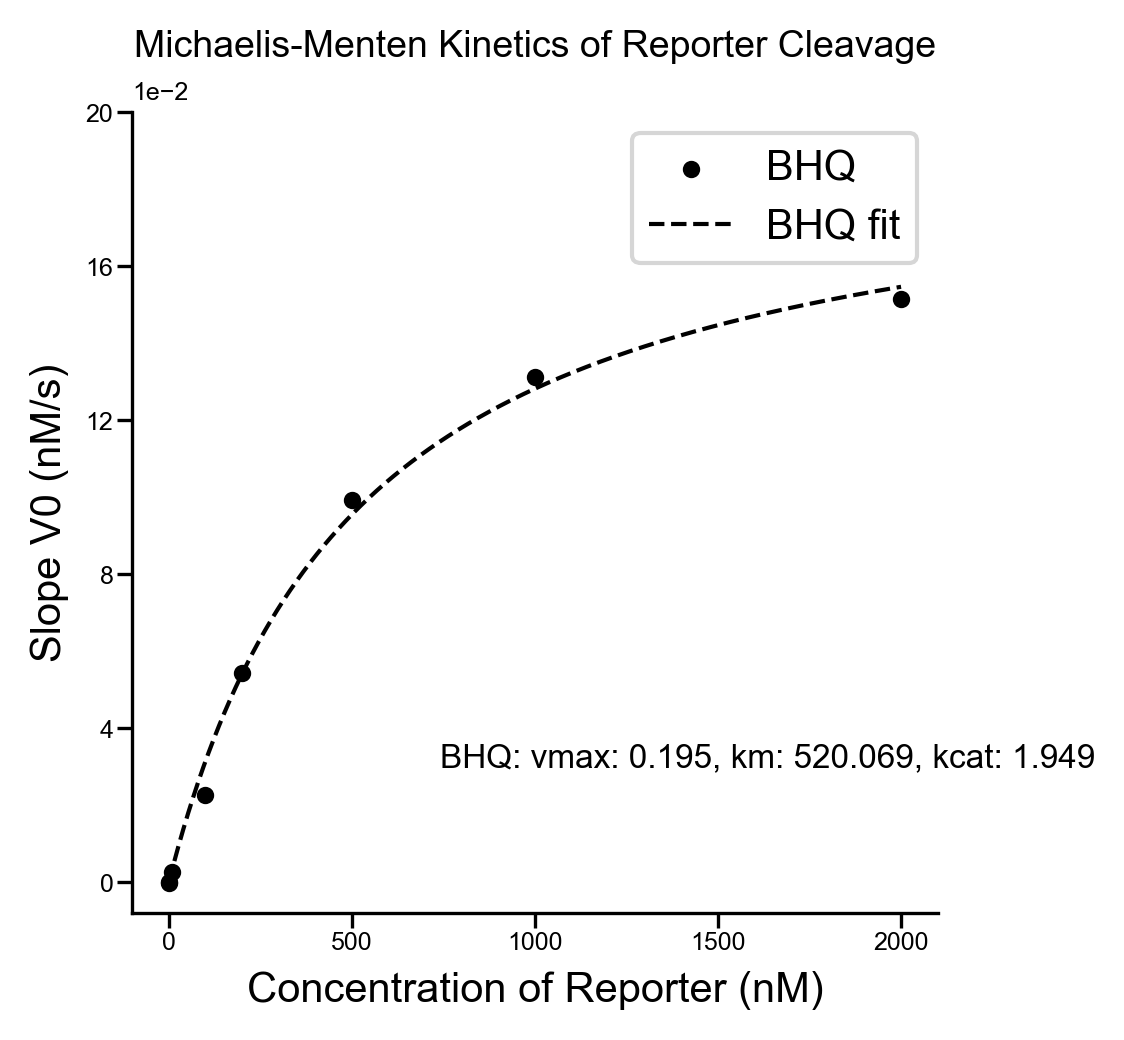

In [38]:
# Plot the slopes vs conc reporter

concs = [0, 1, 10, 100, 200, 500, 1000, 2000]

bhq_slope_data = [bhq_slopes.bhq_0nm, bhq_slopes.bhq_1nm, bhq_slopes.bhq_10nm,
                  bhq_slopes.bhq_100nm, bhq_slopes.bhq_200nm, bhq_slopes.bhq_500nm,
                  bhq_slopes.bhq_1000nm, bhq_slopes.bhq_2000nm]

tamra_slope_data = [tamra_slopes.tamra_0nm, tamra_slopes.tamra_1nm, tamra_slopes.tamra_10nm,
                    tamra_slopes.tamra_100nm, tamra_slopes.tamra_200nm, tamra_slopes.tamra_500nm,
                    tamra_slopes.tamra_1000nm, tamra_slopes.tamra_2000nm]

fig, ax = plt.subplots(1, 1, figsize=(2*4.4*cm, 2*4.4*cm), dpi=300)

ax.scatter(concs, bhq_slope_data, c='k', label='BHQ', s=10)
#ax.scatter(concs, tamra_slope_data, c='r', label='TAMRA')

# fit a model to the data


def mm_kinetcs(x, v_max, k_m): return (v_max * x) / (k_m + x)


popt_kin_tamra, pcov_kin_tamra = curve_fit(mm_kinetcs, concs, tamra_slope_data)
popt_kin_bhq, pcov_kin_bhq = curve_fit(mm_kinetcs, concs, bhq_slope_data)

x_vals_for_fit = np.linspace(0, 2000, 1000000)

#ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_tamra), c='r', label='TAMRA fit')
ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_bhq),
        c='k', label='BHQ fit', ls='--', lw=1)


ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))

ax.tick_params(axis='both', labelsize=6,
               direction='out', which='both')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#axis.tick_params(axis='y', labelsize=axis_tick_size)

ax.yaxis.get_offset_text().set_fontsize(6)
ax.yaxis.set_tick_params(labelsize=6)
ax.tick_params(axis='both', which='major', pad=1)

ax.set_xticks([0, 500, 1000, 1500, 2000])
ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2])
active_enzyme_nM = .1

if True:
    ax.set_title('Michaelis-Menten Kinetics of Reporter Cleavage', fontsize=9)
    ax.text(
        740, .03, f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}', fontsize=8)

    ax.set_xlabel('Concentration of Reporter (nM)')
    ax.set_ylabel('Slope V0 (nM/s)')

    ax.legend()


plt.savefig('./charts/2C_BHQ1_Kinetics.png', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2C_BHQ1_Kinetics.svg', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2C_BHQ1_Kinetics.eps', dpi=2000, bbox_inches='tight')


# TAMRA Kinetics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


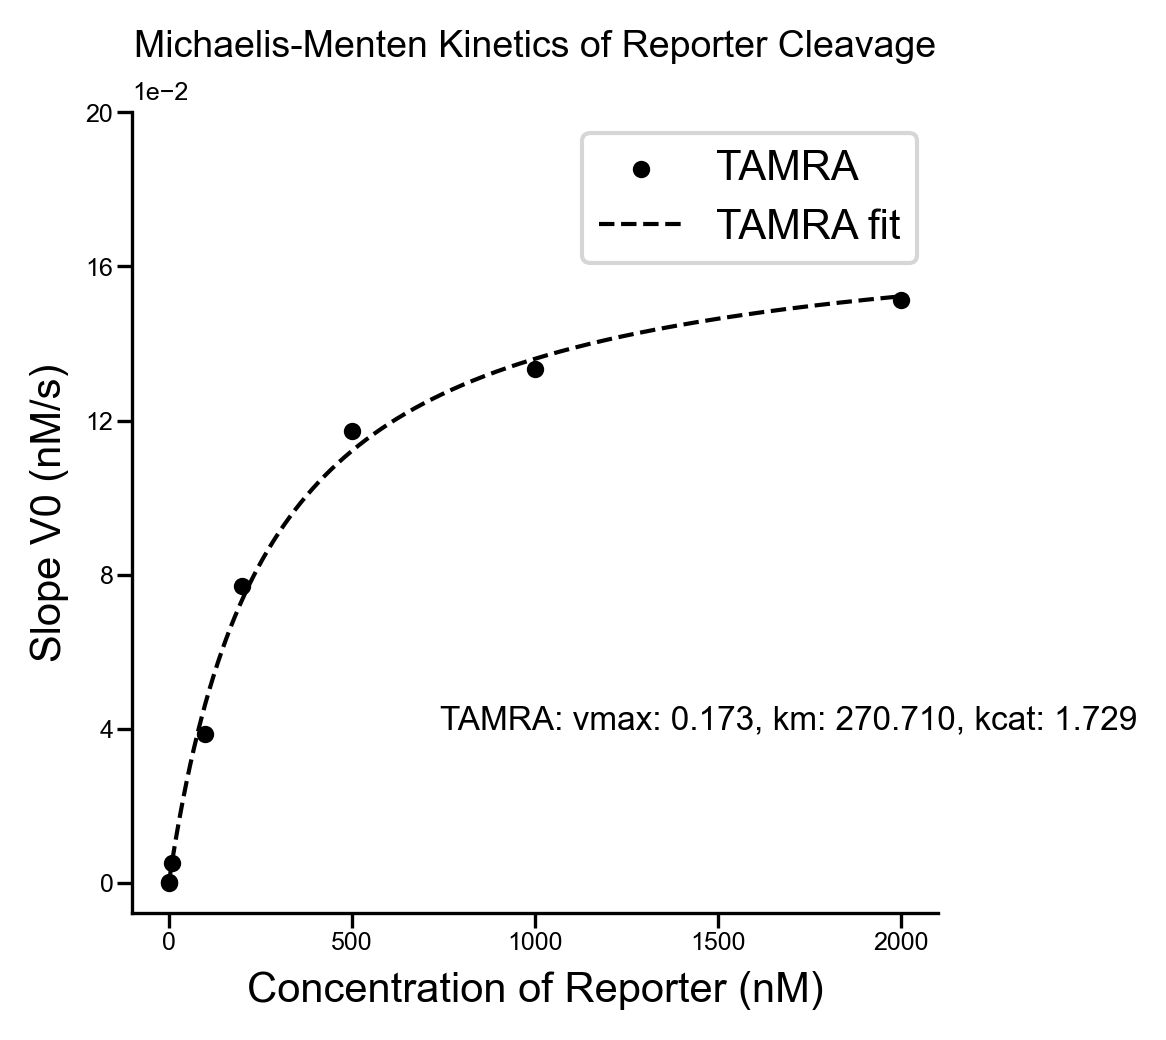

In [39]:
# Plot the slopes vs conc reporter

concs = [0, 1, 10, 100, 200, 500, 1000, 2000]

bhq_slope_data = [bhq_slopes.bhq_0nm, bhq_slopes.bhq_1nm, bhq_slopes.bhq_10nm,
                  bhq_slopes.bhq_100nm, bhq_slopes.bhq_200nm, bhq_slopes.bhq_500nm,
                  bhq_slopes.bhq_1000nm, bhq_slopes.bhq_2000nm]

tamra_slope_data = [tamra_slopes.tamra_0nm, tamra_slopes.tamra_1nm, tamra_slopes.tamra_10nm,
                    tamra_slopes.tamra_100nm, tamra_slopes.tamra_200nm, tamra_slopes.tamra_500nm,
                    tamra_slopes.tamra_1000nm, tamra_slopes.tamra_2000nm]

fig, ax = plt.subplots(1, 1, figsize=(2*4.4*cm, 2*4.4*cm), dpi=300)

#ax.scatter(concs, bhq_slope_data, c='k', label='BHQ')
ax.scatter(concs, tamra_slope_data, c='k', label='TAMRA', s=10)

# fit a model to the data


def mm_kinetcs(x, v_max, k_m): return (v_max * x) / (k_m + x)


popt_kin_tamra, pcov_kin_tamra = curve_fit(mm_kinetcs, concs, tamra_slope_data)
popt_kin_bhq, pcov_kin_bhq = curve_fit(mm_kinetcs, concs, bhq_slope_data)

x_vals_for_fit = np.linspace(0, 2000, 1000000)

ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_tamra),
        c='k', label='TAMRA fit', ls='--', lw=1)
#ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_bhq), c='k', label='BHQ fit')


ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))

ax.tick_params(axis='both', labelsize=6,
               direction='out', which='both')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#axis.tick_params(axis='y', labelsize=axis_tick_size)

ax.yaxis.get_offset_text().set_fontsize(6)
ax.yaxis.set_tick_params(labelsize=6)
ax.tick_params(axis='both', which='major', pad=1)

ax.set_xticks([0, 500, 1000, 1500, 2000])
ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2])
active_enzyme_nM = .1

if True:

    ax.text(
        740, .04, f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}', fontsize=8)
    #ax.text(740, .03, f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}', fontsize=8)
    ax.set_title('Michaelis-Menten Kinetics of Reporter Cleavage', fontsize=9)

    ax.set_xlabel('Concentration of Reporter (nM)')
    ax.set_ylabel('Slope V0 (nM/s)')

    ax.legend()


plt.savefig('./charts/2D_TAMRA_Kinetics.png', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2D_TAMRA_Kinetics.svg', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2D_TAMRA_Kinetics.eps', dpi=2000, bbox_inches='tight')


# Fig 4F: BHQ in DTT

In [40]:
# Read the Data
#F = '../../data/raw_data/DTT_TRY3_NEWDAY.csv'
F = '../../data/raw_data/dtttry3try2.csv'

well_dict = {
    'tamra_0': ['A1', 'A2', 'A3'],
    'tamra_1': ['B1', 'B2', 'B3'],
    'tamra_5': ['C1', 'C2', 'C3'],
    'tamra_10': ['D1', 'D2', 'D3'],
    'bhq_0': ['E1', 'E2', 'E3'],
    'bhq_1': ['F1', 'F2', 'F3'],
    'bhq_5': ['G1', 'G2', 'G3'],
    'bhq_10': ['H1', 'H2', 'H3']
}

dttdat = nk.read_and_process_general_conc_quotient_data(F, well_dict)


(57.9956335298277, 655.9162216889499)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


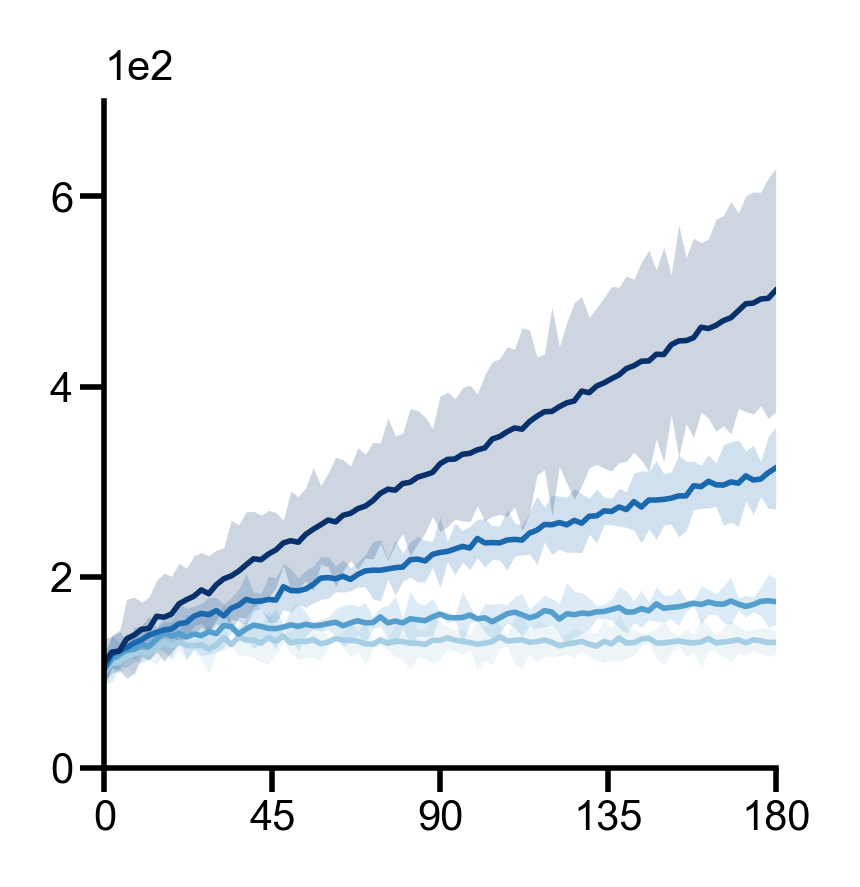

In [41]:
x_bhq = nk.tc(dttdat.bhq_0.fam.index)
lns_bhq = [[x_bhq, dttdat.bhq_0.fam.mean(axis=1)], [x_bhq, dttdat.bhq_1.fam.mean(
    axis=1)], [x_bhq, dttdat.bhq_5.fam.mean(axis=1)], [x_bhq, dttdat.bhq_10.fam.mean(axis=1)]]
errs_bhq = [dttdat.bhq_0.fam.std(axis=1), dttdat.bhq_1.fam.std(
    axis=1), dttdat.bhq_5.fam.std(axis=1), dttdat.bhq_10.fam.std(axis=1)]
labels_bhq = ['0 mM', '1 mM', '5 mM', '10 mM']
axis_names_bhq = ['Time (min)', 'FAM Fluorescence']

bhq_axp = nkp.AxisPackage(lns_bhq, labels_bhq, errs_bhq, axis_names_bhq)


axis_packages = [[bhq_axp]]
fig, ax = nkp.general_lineplot_errorfill(
    axis_packages, stdmult=std_mult, neg_std_mult=neg_std_mult, publish_ready=True, figsize=(4.4*cm, 4.4*cm), dpi=500)

print(ax[0][0].get_ylim())

a = ax[0][0]
a.set_ylim([0, 700])
a.set_yticks([0, 200, 400, 600])
a.set_xticks([0, 45, 90, 135, 180])
a.set_xlim([0, 180])
a.tick_params(axis='both', which='major', pad=1)

plt.savefig('./charts/2_DTT_BHQ_DTT_Reads.png', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2_DTT_BHQ_DTT_Reads.svg', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2_DTT_BHQ_DTT_Reads.eps', dpi=2000, bbox_inches='tight')


# Fig 2G: TAMR in DTT

(454.73177919562875, 986.6869610137901)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


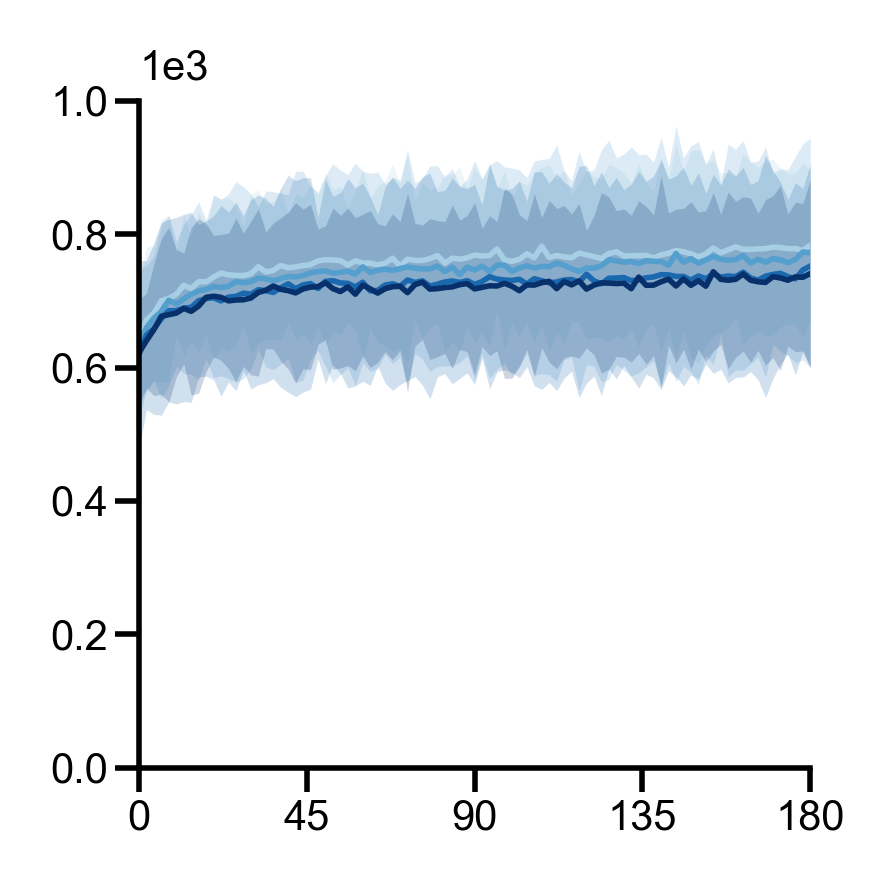

In [42]:


x_TAMRA = nk.tc(dttdat.tamra_0.fam.index)
lns_TAMRA = [[x_TAMRA, dttdat.tamra_0.fam.mean(axis=1)], [x_TAMRA, dttdat.tamra_1.fam.mean(
    axis=1)], [x_TAMRA, dttdat.tamra_5.fam.mean(axis=1)], [x_TAMRA, dttdat.tamra_10.fam.mean(axis=1)]]
errs_TAMRA = [dttdat.tamra_0.fam.std(axis=1), dttdat.tamra_1.fam.std(
    axis=1), dttdat.tamra_5.fam.std(axis=1), dttdat.tamra_10.fam.std(axis=1)]
labels_TAMRA = ['0 mM', '1 mM', '5 mM', '10 mM']
axis_names_TAMRA = ['Time (min)', 'FAM Fluorescence']

tamra_axp = nkp.AxisPackage(lns_TAMRA, labels_TAMRA,
                            errs_TAMRA, axis_names_TAMRA)


axis_packages = [[tamra_axp]]
fig, ax = nkp.general_lineplot_errorfill(
    axis_packages, stdmult=std_mult, neg_std_mult=neg_std_mult, publish_ready=True, figsize=(4.4*cm, 4.4*cm), dpi=500)

print(ax[0][0].get_ylim())

a = ax[0][0]
a.set_ylim([0, 1000])
a.set_yticks([0, 200,400,600,800,1000])
a.set_xticks([0, 45, 90, 135, 180])
a.set_xlim([0, 180])
a.tick_params(axis='both', which='major', pad=1)

plt.savefig('./charts/2_DTT_TAMRA_DTT_Reads.png',
            dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2_DTT_TAMRA_DTT_Reads.svg',
            dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2_DTT_TAMRA_DTT_Reads.eps',
            dpi=2000, bbox_inches='tight')


# Combined Kinetic Plots

/var/folders/g4/cjms28gd4hn9wy923zjttby40000gp/T/ipykernel_55271/452308260.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(concs, bhq_slope_data, c=colors[1], label='BHQ', s=10, marker='^')
/var/folders/g4/cjms28gd4hn9wy923zjttby40000gp/T/ipykernel_55271/452308260.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(concs, tamra_slope_data,


TAMRA: vmax: 0.173, km: 270.710, kcat: 1.729, kcat/km: 0.00639
BHQ: vmax: 0.195, km: 520.069, kcat: 1.949, kcat/km: 0.00375


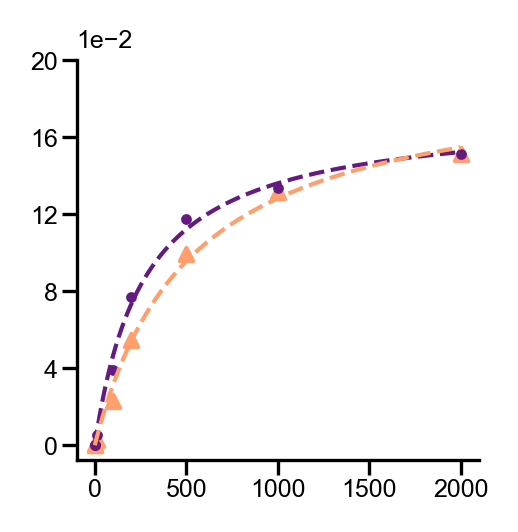

In [43]:
# Plot the slopes vs conc reporter

big_title_size = 9
small_title_size = 9
axis_size = 8
legend_size = 8
axis_tick_size = 6

ocolormap = mpl.colormaps['magma']
colors = ocolormap(np.linspace(0.3, .8, 1024))
colormap = mpl.colors.ListedColormap(colors)
colors = colormap(np.linspace(0, 1, 2))

concs = [0, 1, 10, 100, 200, 500, 1000, 2000]

bhq_slope_data = [bhq_slopes.bhq_0nm, bhq_slopes.bhq_1nm, bhq_slopes.bhq_10nm,
                  bhq_slopes.bhq_100nm, bhq_slopes.bhq_200nm, bhq_slopes.bhq_500nm,
                  bhq_slopes.bhq_1000nm, bhq_slopes.bhq_2000nm]

tamra_slope_data = [tamra_slopes.tamra_0nm, tamra_slopes.tamra_1nm, tamra_slopes.tamra_10nm,
                    tamra_slopes.tamra_100nm, tamra_slopes.tamra_200nm, tamra_slopes.tamra_500nm,
                    tamra_slopes.tamra_1000nm, tamra_slopes.tamra_2000nm]

fig, ax = plt.subplots(1, 1, figsize=(4.4*cm, 4.4*cm), dpi=300)

ax.scatter(concs, bhq_slope_data, c=colors[1], label='BHQ', s=10, marker='^')
ax.scatter(concs, tamra_slope_data,
           c=colors[0], label='TAMRA', s=10, marker='.')

# fit a model to the data


def mm_kinetcs(x, v_max, k_m): return (v_max * x) / (k_m + x)


popt_kin_tamra, pcov_kin_tamra = curve_fit(mm_kinetcs, concs, tamra_slope_data)
popt_kin_bhq, pcov_kin_bhq = curve_fit(mm_kinetcs, concs, bhq_slope_data)

x_vals_for_fit = np.linspace(0, 2000, 1000000)

ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_tamra),
        c=colors[0], label='TAMRA fit', ls='--', lw=1)
ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_bhq),
        c=colors[1], label='BHQ fit', ls='--', lw=1)


ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))

ax.tick_params(axis='both', labelsize=axis_tick_size,
               direction='out', which='both')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#axis.tick_params(axis='y', labelsize=axis_tick_size)

ax.yaxis.get_offset_text().set_fontsize(axis_tick_size)
ax.yaxis.set_tick_params(labelsize=axis_tick_size)
ax.tick_params(axis='both', which='major', pad=1)

ax.set_xticks([0, 500, 1000, 1500, 2000])
ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2])

active_enzyme_nM = .1

print(f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}, kcat/km: {popt_kin_tamra[0]/active_enzyme_nM/popt_kin_tamra[1]:.5f}')
print(f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}, kcat/km: {popt_kin_bhq[0]/active_enzyme_nM/popt_kin_bhq[1]:.5f}')

if False:
    ax.set_title('Michaelis-Menten Kinetics of Reporter Cleavage', fontsize=9)
    ax.text(
        740, .04, f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}', fontsize=8)
    ax.text(
        740, .03, f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}', fontsize=8)

    ax.set_xlabel('Concentration of Reporter (nM)')
    ax.set_ylabel('Slope V0 (nM/s)')

    ax.legend()

plt.savefig('./charts/2COMB_allKinetics.png', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2COMB_allKinetics.svg', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2COMB_allKinetics.eps', dpi=2000, bbox_inches='tight')


/var/folders/g4/cjms28gd4hn9wy923zjttby40000gp/T/ipykernel_55271/1583442665.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(concs, bhq_slope_data, c=colors[1], label='BHQ', s=10, marker='^')
/var/folders/g4/cjms28gd4hn9wy923zjttby40000gp/T/ipykernel_55271/1583442665.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(concs, tamra_slope_data,


TAMRA: vmax: 0.173, km: 270.710, kcat: 1.729, kcat/km: 0.00639
BHQ: vmax: 0.195, km: 520.069, kcat: 1.949, kcat/km: 0.00375
0.13589375050013333
0.4661779428834727


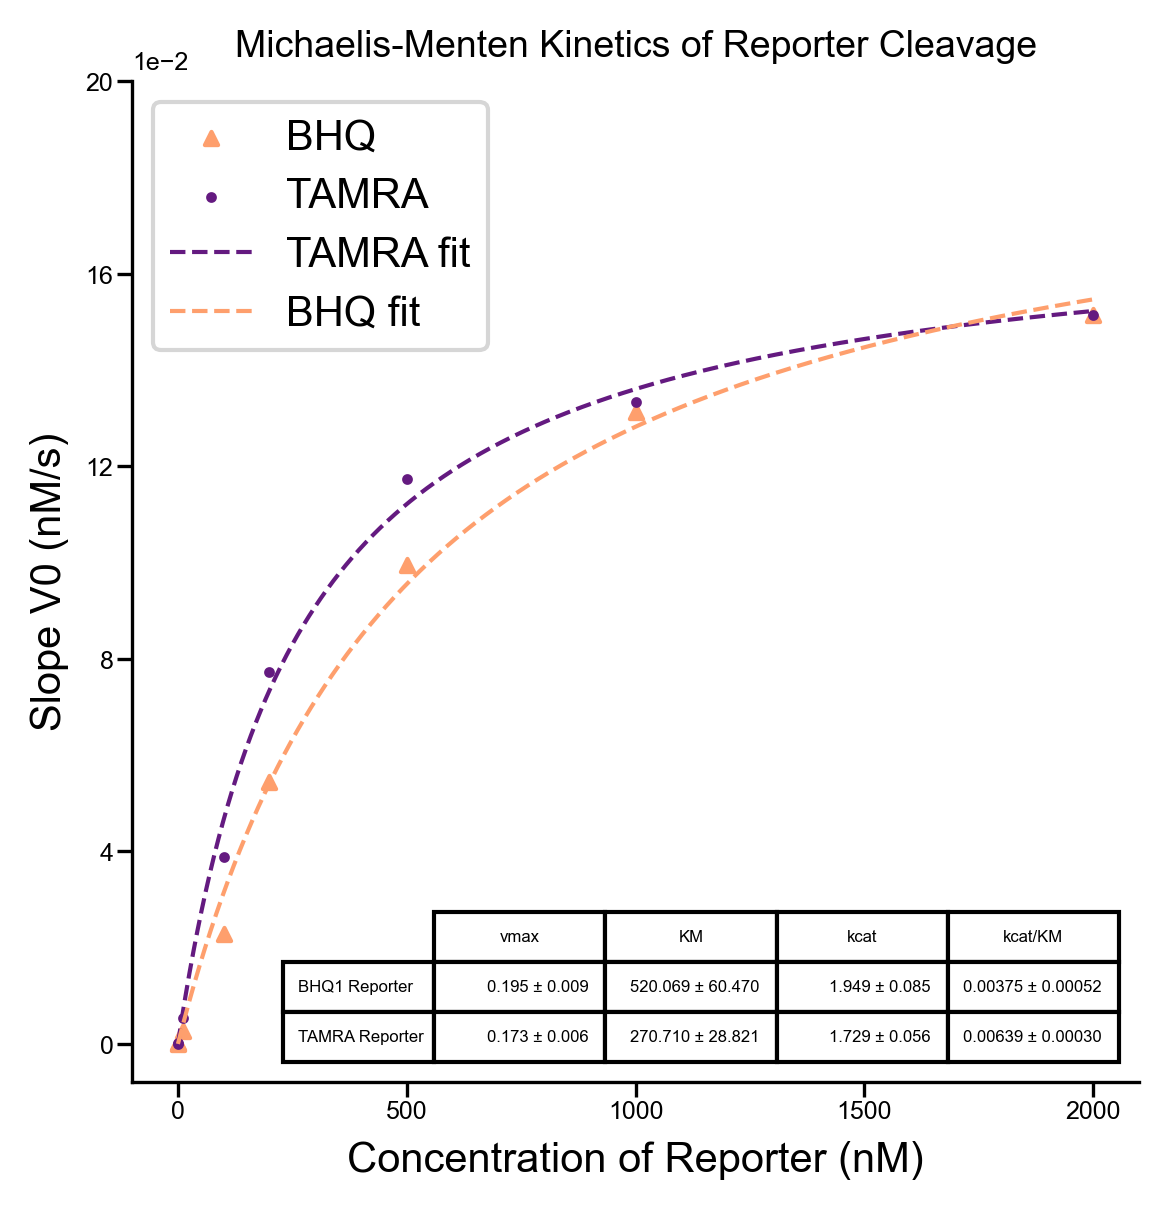

In [44]:
# Plot the slopes vs conc reporter

big_title_size = 9
small_title_size = 9
axis_size = 8
legend_size = 8
axis_tick_size = 6

ocolormap = mpl.colormaps['magma']
colors = ocolormap(np.linspace(0.3, .8, 1024))
colormap = mpl.colors.ListedColormap(colors)
colors = colormap(np.linspace(0, 1, 2))

concs = [0, 1, 10, 100, 200, 500, 1000, 2000]

bhq_slope_data = [bhq_slopes.bhq_0nm, bhq_slopes.bhq_1nm, bhq_slopes.bhq_10nm,
                bhq_slopes.bhq_100nm, bhq_slopes.bhq_200nm, bhq_slopes.bhq_500nm,
                bhq_slopes.bhq_1000nm, bhq_slopes.bhq_2000nm]

tamra_slope_data = [tamra_slopes.tamra_0nm, tamra_slopes.tamra_1nm, tamra_slopes.tamra_10nm,
                tamra_slopes.tamra_100nm, tamra_slopes.tamra_200nm, tamra_slopes.tamra_500nm,
                tamra_slopes.tamra_1000nm, tamra_slopes.tamra_2000nm]

fig, ax = plt.subplots(1, 1, figsize=(2.5*4.4*cm, 2.5*4.4*cm), dpi=300)

ax.scatter(concs, bhq_slope_data, c=colors[1], label='BHQ', s=10, marker='^')
ax.scatter(concs, tamra_slope_data,
           c=colors[0], label='TAMRA', s=10, marker='.')

# fit a model to the data
mm_kinetcs = lambda x, v_max, k_m: (v_max * x) / (k_m + x)

popt_kin_tamra, pcov_kin_tamra = curve_fit(mm_kinetcs, concs, tamra_slope_data)
popt_kin_bhq, pcov_kin_bhq = curve_fit(mm_kinetcs, concs, bhq_slope_data)
perr_kin_bhq = np.sqrt(np.diag(pcov_kin_bhq))
perr_kin_tamra = np.sqrt(np.diag(pcov_kin_tamra))

x_vals_for_fit = np.linspace(0, 2000, 1000000)

ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_tamra),
        c=colors[0], label='TAMRA fit', ls='--', lw=1)
ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_bhq),
        c=colors[1], label='BHQ fit', ls='--', lw=1)


ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))

ax.tick_params(axis='both', labelsize=axis_tick_size,
               direction='out', which='both')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# axis.tick_params(axis='y', labelsize=axis_tick_size)

ax.yaxis.get_offset_text().set_fontsize(axis_tick_size)
ax.yaxis.set_tick_params(labelsize=axis_tick_size)
ax.tick_params(axis='both', which='major', pad=1)

ax.set_xticks([0, 500, 1000, 1500, 2000])
ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2])

active_enzyme_nM = .1

def kcat_over_km(vmax, vmaxerr, km, kmerr, vmax_km_cov, enzyme_conc):
    f = vmax / km
    t1 = (vmaxerr / vmax)**2
    t2 = (kmerr / km)**2
    t3 = 2 * (vmax_km_cov / (vmax * km))
    print(vmax_km_cov)
    return (f * np.sqrt(t1 + t2 - t3)) / enzyme_conc




print(f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}, kcat/km: {popt_kin_tamra[0]/active_enzyme_nM/popt_kin_tamra[1]:.5f}')
print(f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}, kcat/km: {popt_kin_bhq[0]/active_enzyme_nM/popt_kin_bhq[1]:.5f}')

# defining the attributes
col_labels = ['vmax', 'KM', 'kcat', 'kcat/KM']
row_labels = ['BHQ1 Reporter', 'TAMRA Reporter']
tamra_km_kcat_err = kcat_over_km(popt_kin_tamra[0], perr_kin_tamra[0], popt_kin_tamra[1], perr_kin_tamra[1], pcov_kin_tamra[0][1], active_enzyme_nM)
bhq_km_kcat_err = kcat_over_km(popt_kin_bhq[0], perr_kin_bhq[0], popt_kin_bhq[1], perr_kin_bhq[1], pcov_kin_bhq[0][1], active_enzyme_nM)


table_vals = [[f'{popt_kin_bhq[0]:.3f} ± {perr_kin_bhq[0]:.3f}',
         f'{popt_kin_bhq[1]:.3f} ± {perr_kin_bhq[1]:.3f}',
         f'{popt_kin_bhq[0]/active_enzyme_nM:.3f} ± {perr_kin_bhq[0]/active_enzyme_nM:.3f}',
         f'{popt_kin_bhq[0]/active_enzyme_nM/popt_kin_bhq[1]:.5f} ± {tamra_km_kcat_err:.5f}'],
         [f'{popt_kin_tamra[0]:.3f} ± {perr_kin_tamra[0]:.3f}',
         f'{popt_kin_tamra[1]:.3f} ± {perr_kin_tamra[1]:.3f}',
         f'{popt_kin_tamra[0]/active_enzyme_nM:.3f} ± {perr_kin_tamra[0]/active_enzyme_nM:.3f}',
         f'{popt_kin_tamra[0]/active_enzyme_nM/popt_kin_tamra[1]:.5f} ± {bhq_km_kcat_err:.5f}']
         ]

ax.table(cellText=table_vals,
                     colWidths = [0.17] * 4,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'lower right',
                     fontsize = 1)

if True:
    ax.set_title('Michaelis-Menten Kinetics of Reporter Cleavage', fontsize = 9)
    #ax.text(740, .04, f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}', fontsize = 8)
    #ax.text(740, .03, f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}', fontsize = 8)


    ax.set_xlabel('Concentration of Reporter (nM)')
    ax.set_ylabel('Slope V0 (nM/s)')

    ax.legend()

plt.savefig('./charts/2COMB_allKinetics_verbose.png', dpi = 2000, bbox_inches = 'tight')


/var/folders/g4/cjms28gd4hn9wy923zjttby40000gp/T/ipykernel_55271/3663515277.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(concs, bhq_slope_data_rfu, c=colors[1], label='BHQ', s=10, marker='^')
/var/folders/g4/cjms28gd4hn9wy923zjttby40000gp/T/ipykernel_55271/3663515277.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(concs, tamra_slope_data_rfu,


TAMRA: vmax: 4.272, km: 270.710, kcat: 42.723, kcat/km: 0.15782
BHQ: vmax: 4.350, km: 520.067, kcat: 43.499, kcat/km: 0.08364


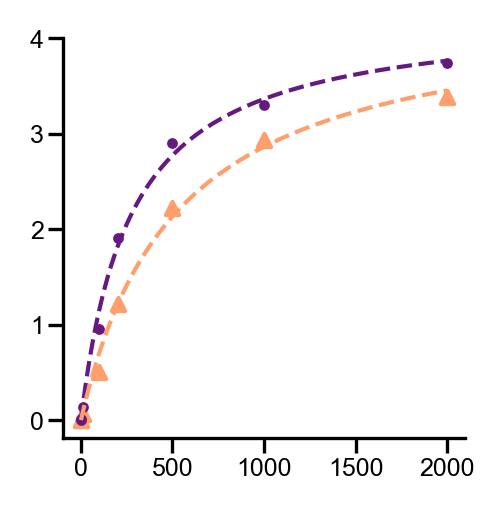

In [45]:
# IN RFU
bhq_slopes_rfu = DotMap({
    'bhq_0nm': find_slope(raw_data.bhq_0nm, etime, start_time=stime),
    'bhq_1nm': find_slope(raw_data.bhq_1nm, etime, start_time=stime),
    'bhq_10nm': find_slope(raw_data.bhq_10nm, etime, start_time=stime),
    'bhq_100nm': find_slope(raw_data.bhq_100nm, etime, start_time=stime),
    'bhq_200nm': find_slope(raw_data.bhq_200nm, etime, start_time=stime),
    'bhq_500nm': find_slope(raw_data.bhq_500nm, etime, start_time=stime),
    'bhq_1000nm': find_slope(raw_data.bhq_1000nm, etime, start_time=stime),
    'bhq_2000nm': find_slope(raw_data.bhq_2000nm, etime, start_time=stime)
})

tamra_slopes_rfu = DotMap({
    'tamra_0nm': find_slope(raw_data.tamra_0nm, etime, start_time=stime),  
    'tamra_1nm': find_slope(raw_data.tamra_1nm, etime, start_time=stime),
    'tamra_10nm': find_slope(raw_data.tamra_10nm, etime, start_time=stime),
    'tamra_100nm': find_slope(raw_data.tamra_100nm, etime, start_time=stime),
    'tamra_200nm': find_slope(raw_data.tamra_200nm, etime, start_time=stime),
    'tamra_500nm': find_slope(raw_data.tamra_500nm, etime, start_time=stime),
    'tamra_1000nm': find_slope(raw_data.tamra_1000nm, etime, start_time=stime),
    'tamra_2000nm': find_slope(raw_data.tamra_2000nm, etime, start_time=stime)
})



# Plot the slopes vs conc reporter

big_title_size = 9
small_title_size = 9
axis_size = 8
legend_size = 8
axis_tick_size = 6

ocolormap = mpl.colormaps['magma']
colors = ocolormap(np.linspace(0.3, .8, 1024))
colormap = mpl.colors.ListedColormap(colors)
colors = colormap(np.linspace(0, 1, 2))

concs = [0, 1, 10, 100, 200, 500, 1000, 2000]

bhq_slope_data_rfu = [bhq_slopes_rfu.bhq_0nm, bhq_slopes_rfu.bhq_1nm, bhq_slopes_rfu.bhq_10nm, 
                bhq_slopes_rfu.bhq_100nm, bhq_slopes_rfu.bhq_200nm, bhq_slopes_rfu.bhq_500nm,
                bhq_slopes_rfu.bhq_1000nm, bhq_slopes_rfu.bhq_2000nm]

tamra_slope_data_rfu = [tamra_slopes_rfu.tamra_0nm, tamra_slopes_rfu.tamra_1nm, tamra_slopes_rfu.tamra_10nm,
                tamra_slopes_rfu.tamra_100nm, tamra_slopes_rfu.tamra_200nm, tamra_slopes_rfu.tamra_500nm,
                tamra_slopes_rfu.tamra_1000nm, tamra_slopes_rfu.tamra_2000nm]


fig, ax = plt.subplots(1, 1, figsize=(4.4*cm, 4.4*cm), dpi=300)

ax.scatter(concs, bhq_slope_data_rfu, c=colors[1], label='BHQ', s=10, marker='^')
ax.scatter(concs, tamra_slope_data_rfu,
           c=colors[0], label='TAMRA', s=10, marker='.')

# fit a model to the data


def mm_kinetcs(x, v_max, k_m): return (v_max * x) / (k_m + x)


popt_kin_tamra, pcov_kin_tamra = curve_fit(mm_kinetcs, concs, tamra_slope_data_rfu)
popt_kin_bhq, pcov_kin_bhq = curve_fit(mm_kinetcs, concs, bhq_slope_data_rfu)

x_vals_for_fit = np.linspace(0, 2000, 1000000)

ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_tamra),
        c=colors[0], label='TAMRA fit', ls='--', lw=1)
ax.plot(x_vals_for_fit, mm_kinetcs(x_vals_for_fit, *popt_kin_bhq),
        c=colors[1], label='BHQ fit', ls='--', lw=1)


#ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))

ax.tick_params(axis='both', labelsize=axis_tick_size,
               direction='out', which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#axis.tick_params(axis='y', labelsize=axis_tick_size)

ax.yaxis.get_offset_text().set_fontsize(axis_tick_size)
ax.yaxis.set_tick_params(labelsize=axis_tick_size)
ax.tick_params(axis='both', which='major', pad=1)

ax.set_xticks([0, 500, 1000, 1500, 2000])
ax.set_yticks([0, 1,2,3,4])

active_enzyme_nM = .1

print(f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}, kcat/km: {popt_kin_tamra[0]/active_enzyme_nM/popt_kin_tamra[1]:.5f}')
print(f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}, kcat/km: {popt_kin_bhq[0]/active_enzyme_nM/popt_kin_bhq[1]:.5f}')

if False:
    ax.set_title('Michaelis-Menten Kinetics of Reporter Cleavage', fontsize=9)
    ax.text(
        740, .04, f'TAMRA: vmax: {popt_kin_tamra[0]:.3f}, km: {popt_kin_tamra[1]:.3f}, kcat: {popt_kin_tamra[0]/active_enzyme_nM:.3f}', fontsize=8)
    ax.text(
        740, .03, f'BHQ: vmax: {popt_kin_bhq[0]:.3f}, km: {popt_kin_bhq[1]:.3f}, kcat: {popt_kin_bhq[0]/active_enzyme_nM:.3f}', fontsize=8)

    ax.set_xlabel('Concentration of Reporter (nM)')
    ax.set_ylabel('Slope V0 (nM/s)')

    ax.legend()

plt.savefig('./charts/2COMB_allKinetics_RFU.png', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2COMB_allKinetics_RFU.svg', dpi=2000, bbox_inches='tight')
plt.savefig('./charts/2COMB_allKinetics_RFU.eps', dpi=2000, bbox_inches='tight')
